In [51]:
!pip install dataframe-image
!pip install fpdf

In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, average_precision_score, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF
from PIL import Image
import dataframe_image as dfi


In [87]:
def plot_pr_curves_all_models(gt, model_outputs, attribute, filename='pr_curve', append=False):
    plt.figure(figsize=(8,6))

    for model_name, probs in model_outputs.items():
        y_true = gt[attribute]
        y_scores = probs[attribute]

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = average_precision_score(y_true, y_scores)

        plt.plot(recall, precision, label=f'{model_name} (AP={ap:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves for "{attribute}"')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.savefig(f'{filename}.png')
    if append:
      image_files.append(f'{filename}.png')

def plot_heatmap(summary_df, metric="F1", figsize=(10, 6), cmap="Spectral", append=False):
    """
    Plot a heatmap of a chosen metric across models and attributes with color scale fixed between 0 and 1.

    Parameters:
    - summary_df: DataFrame with columns ['Model', 'Attribute', 'Precision', 'Recall', 'F1', 'Accuracy']
    - metric: Which metric to visualize ("Precision", "Recall", "F1", "Accuracy")
    - figsize: Tuple for figure size
    - cmap: Colormap for heatmap (default "Spectral" for colorblind-friendly)
    """
    if metric not in summary.columns:
        raise ValueError(f"Metric '{metric}' is not valid. Choose from {summary.columns}")

    pivot_df = summary_df.pivot(index="Attribute", columns="Model", values=metric)

    plt.figure(figsize=figsize)
    sns.heatmap(
        pivot_df,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        cbar_kws={'label': metric},
        linewidths=0.5,
        linecolor='gray',
        vmin=0,    # force color scale min
        vmax=1     # force color scale max
    )
    plt.title(f"{metric} Heatmap by Attribute and Model", fontsize=14)
    plt.xlabel("Model")
    plt.ylabel("Attribute")
    plt.tight_layout()
    plt.savefig(f'{metric} heatmap.png')
    if append:
      image_files.append(f'{metric} heatmap.png')
    plt.show()
    plt.close()


def plot_horizontal_bar(summary_df, metric="F1", figsize=(10, 6), filename='bar_chart', append=False):
    """
    Plot a horizontal grouped bar chart of a chosen metric across attributes and models.

    Parameters:
    - summary_df: DataFrame with columns ['Model', 'Attribute', 'Precision', 'Recall', 'F1', 'Accuracy']
    - metric: Which metric to visualize ("Precision", "Recall", "F1", "Accuracy")
    - figsize: Tuple for figure size
    """
    if metric not in summary.columns:
        raise ValueError(f"Metric '{metric}' is not valid. Choose from {summary.columns}.")

    # Pivot the data so rows = attributes, columns = models, values = metric
    pivot_df = summary_df.pivot(index="Attribute", columns="Model", values=metric)

    # Sort attributes by average metric value for better readability
    pivot_df['mean_metric'] = pivot_df.mean(axis=1)
    pivot_df = pivot_df.sort_values('mean_metric', ascending=True)
    pivot_df = pivot_df.drop(columns=['mean_metric'])

    attributes = pivot_df.index.tolist()
    models = pivot_df.columns.tolist()

    y_pos = np.arange(len(attributes))
    bar_height = 0.8 / len(models)  # bar thickness adjusted for number of models

    fig, ax = plt.subplots(figsize=figsize)

    for i, model in enumerate(models):
        # Calculate position for each model's bar within each attribute row
        positions = y_pos - 0.4 + i * bar_height + bar_height/2
        ax.barh(positions, pivot_df[model], height=bar_height, label=model)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(attributes)
    ax.set_xlim(0, 1)  # force x-axis between 0 and 1 for metric scale
    ax.set_xlabel(metric)
    ax.set_title(f"{metric} by Attribute and Model")
    ax.legend(title="Model")
    plt.tight_layout()
    plt.savefig(f'{metric} {filename}.png')
    if append:
      image_files.append(f'{metric} {filename}.png')

def summarize_metrics(gt, model_outputs, thresholds):
    """
    Summarize precision, recall, F1, accuracy, and average precision
    for each model and attribute using attribute-specific thresholds.

    Parameters:
        gt (DataFrame): Ground truth DataFrame with 'case_id' and attributes as columns.
        model_outputs (dict): Dict of model names to DataFrames of predicted probabilities.
        thresholds (dict): Dict mapping attribute names to thresholds.

    Returns:
        DataFrame: Summary metrics.
    """
    attributes = [col for col in gt.columns if col != 'case_id']
    rows = []

    for model_name, probs in model_outputs.items():
        for attr in attributes:
            y_true = gt[attr]
            y_scores = probs[attr]
            threshold = thresholds.get(attr, 0.5)  # default to 0.5 if attr not in thresholds
            y_pred = (y_scores >= threshold).astype(int)

            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            accuracy = accuracy_score(y_true, y_pred)
            avg_prec = average_precision_score(y_true, y_scores)
            kappa = cohen_kappa_score(y_true, y_pred)

            rows.append({
                'Model': model_name,
                'Attribute': attr,
                'Threshold': threshold,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Accuracy': accuracy,
                'Average Precision (AP)': avg_prec,
                'Cohen\'s Kappa': kappa
            })

    summary_df = pd.DataFrame(rows)
    return summary_df


def styled_metrics_by_model(summary_df, filename='summary_metrics.png', append=False, show=True):
    def color_rows_by_model(row):
        # Assign a color based on model name hash (consistent but different per model)
        colors = ['#E3F2FD', '#FFF3E0', '#E8F5E9', '#F3E5F5', '#FFEBEE']
        model_list = summary_df['Model'].unique()
        color_map = {model: colors[i % len(colors)] for i, model in enumerate(model_list)}
        return [f'background-color: {color_map[row["Model"]]}'] * len(row)

    styled = summary_df.style.apply(color_rows_by_model, axis=1) \
                              .background_gradient(subset=['Precision', 'Recall', 'F1', 'Accuracy', 'Average Precision (AP)', 'Cohen\'s Kappa'], cmap='RdYlGn', vmin=0, vmax=1) \
                              .format(precision=2) \
                              .set_properties(**{'text-align': 'center'}) \
                              .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    if show:
      display(styled)

    if filename:
        dfi.export(styled, filename, table_conversion="matplotlib")

    if append:
      image_files.append(filename)

def create_pdf_from_images(image_files, output_pdf="model_evaluation_report.pdf"):
    pdf = FPDF()

    for img_file in image_files:
        cover = Image.open(img_file)
        width, height = cover.size

        # Convert pixels to mm with 1px=0.264583 mm
        width, height = width * 0.264583, height * 0.264583

        # Ensure page is portrait
        orientation = 'P' if width <= height else 'L'
        pdf.add_page(orientation=orientation)

        # Resize image to fit page
        pdf.image(img_file, x=0, y=0, w=210 if orientation=='P' else 297)

    pdf.output(output_pdf, "F")
    print(f"PDF report saved as {output_pdf}")

In [54]:
# Sample case IDs
case_ids = [f'case_{i+1}' for i in range(1000)]

# Attributes
attributes = ['comorbidity_diabetes', 'comorbidity_hypertension', 'medication_aspirin', 'mortality_30_day']

# Generate ground truth (binary)
np.random.seed(42)
ground_truth_data = {'case_id': case_ids}
for attr in attributes:
    ground_truth_data[attr] = np.random.choice([0,1], size=1000, p=[0.7,0.3])
ground_truth_df = pd.DataFrame(ground_truth_data)
ground_truth_df.to_csv('ground_truth.csv', index=False)

# Generate probabilistic model outputs with noise
def generate_model_output_probs(gt_df, noise_level=0.1, model_name='model'):
    np.random.seed(hash(model_name) % 2**32)
    model_data = {'case_id': gt_df['case_id']}
    for attr in attributes:
        probs = gt_df[attr] * (1 - noise_level) + (1 - gt_df[attr]) * noise_level
        probs = probs + np.random.normal(0, noise_level/2, size=len(probs))
        probs = np.clip(probs, 0, 1)
        model_data[attr] = probs
    return pd.DataFrame(model_data)

model_1_df = generate_model_output_probs(ground_truth_df, noise_level=0.35, model_name='Model_1')
model_2_df = generate_model_output_probs(ground_truth_df, noise_level=0.37, model_name='Model_2')
model_3_df = generate_model_output_probs(ground_truth_df, noise_level=0.39, model_name='Model_3')

model_1_df.to_csv('model_output_1.csv', index=False)
model_2_df.to_csv('model_output_2.csv', index=False)
model_3_df.to_csv('model_output_3.csv', index=False)

#Load Data

In [55]:
# Load data
gt_df = pd.read_csv('ground_truth.csv')
model_outputs = {
    'Model_1': pd.read_csv('model_output_1.csv'),
    'Model_2': pd.read_csv('model_output_2.csv'),
    'Model_3': pd.read_csv('model_output_3.csv'),
}

attributes = ['comorbidity_diabetes', 'comorbidity_hypertension', 'medication_aspirin', 'mortality_30_day']



In [56]:
threshold = {
    'comorbidity_diabetes': 0.7,
    'comorbidity_hypertension': 0.5,
    'medication_aspirin': 0.5,
    'mortality_30_day': 0.5
}

In [57]:
image_files = []

In [58]:
summary = summarize_metrics(ground_truth_df, model_outputs, threshold)
print(summary)

      Model                 Attribute  Threshold  Precision    Recall  \
0   Model_1      comorbidity_diabetes        0.7   0.905797  0.434028   
1   Model_1  comorbidity_hypertension        0.5   0.616402  0.758958   
2   Model_1        medication_aspirin        0.5   0.657216  0.819936   
3   Model_1          mortality_30_day        0.5   0.629834  0.811388   
4   Model_2      comorbidity_diabetes        0.7   0.783582  0.364583   
5   Model_2  comorbidity_hypertension        0.5   0.583548  0.739414   
6   Model_2        medication_aspirin        0.5   0.606599  0.768489   
7   Model_2          mortality_30_day        0.5   0.551813  0.758007   
8   Model_3      comorbidity_diabetes        0.7   0.745763  0.305556   
9   Model_3  comorbidity_hypertension        0.5   0.547315  0.697068   
10  Model_3        medication_aspirin        0.5   0.510638  0.694534   
11  Model_3          mortality_30_day        0.5   0.507246  0.747331   

          F1  Accuracy  Average Precision (AP)  Co

In [82]:
styled_metrics_by_model(summary, append=True)

,Model,Attribute,Threshold,Precision,Recall,F1,Accuracy,Average Precision (AP),Cohen's Kappa
0,Model_1,comorbidity_diabetes,0.70,0.91,0.43,0.59,0.82,0.82,0.49
1,Model_1,comorbidity_hypertension,0.50,0.62,0.76,0.68,0.78,0.76,0.52
2,Model_1,medication_aspirin,0.50,0.66,0.82,0.73,0.81,0.80,0.59
3,Model_1,mortality_30_day,0.50,0.63,0.81,0.71,0.81,0.78,0.57
4,Model_2,comorbidity_diabetes,0.70,0.78,0.36,0.50,0.79,0.70,0.39
5,Model_2,comorbidity_hypertension,0.50,0.58,0.74,0.65,0.76,0.69,0.47
6,Model_2,medication_aspirin,0.50,0.61,0.77,0.68,0.77,0.73,0.51
7,Model_2,mortality_30_day,0.50,0.55,0.76,0.64,0.76,0.68,0.46
8,Model_3,comorbidity_diabetes,0.70,0.75,0.31,0.43,0.77,0.64,0.32
9,Model_3,comorbidity_hypertension,0.50,0.55,0.70,0.61,0.73,0.64,0.41


Styled table saved as: summary_metrics.png


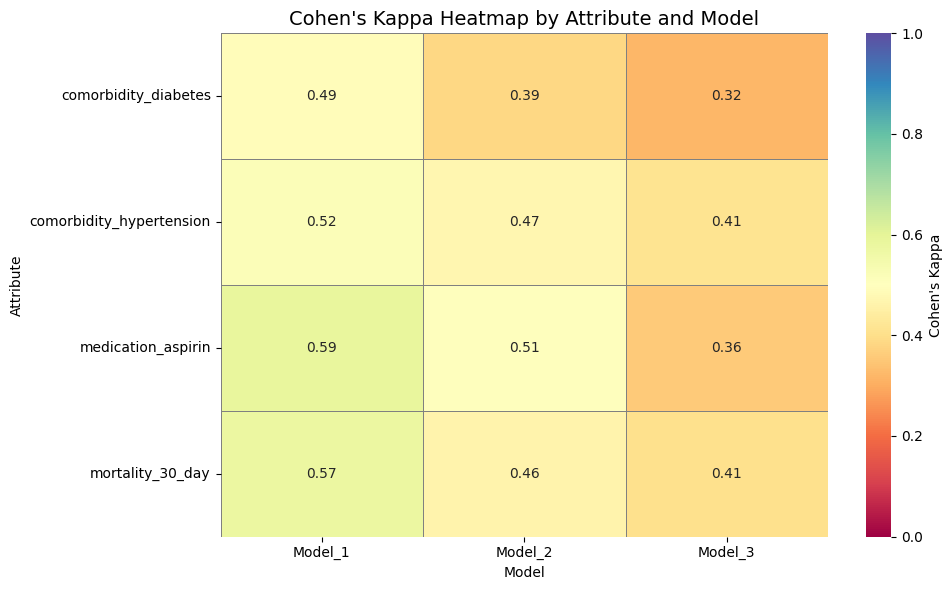

In [60]:
plot_heatmap(summary, metric="Cohen\'s Kappa", figsize=(10, 6), cmap="Spectral")
plt.show()
plt.close()

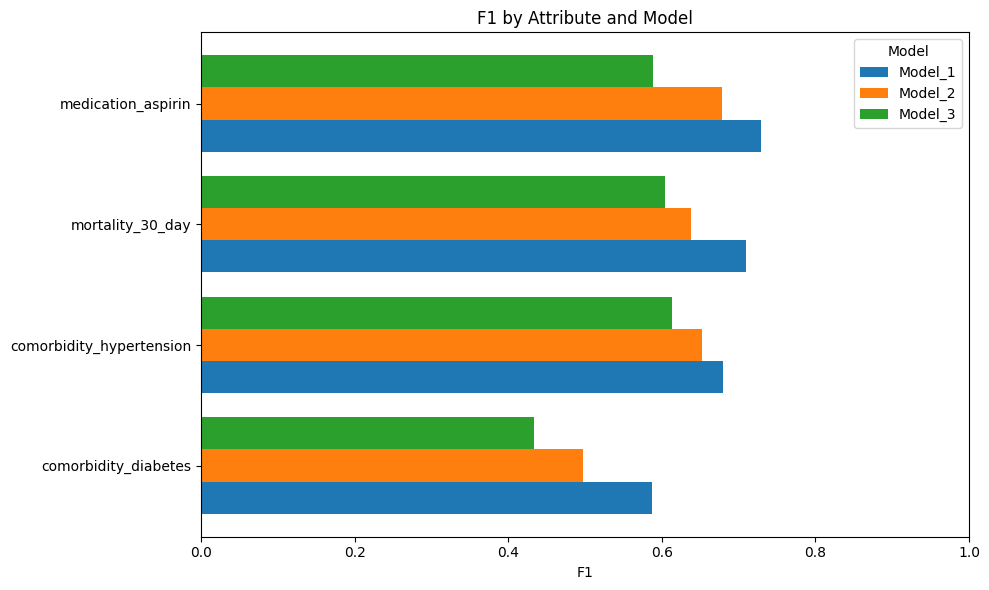

In [61]:
plot_horizontal_bar(summary, metric="F1", figsize=(10, 6), append=True)
plt.show()
plt.close()

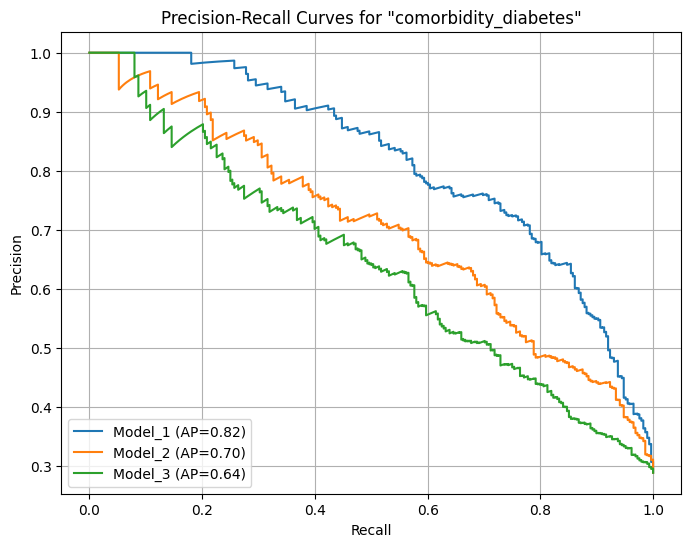

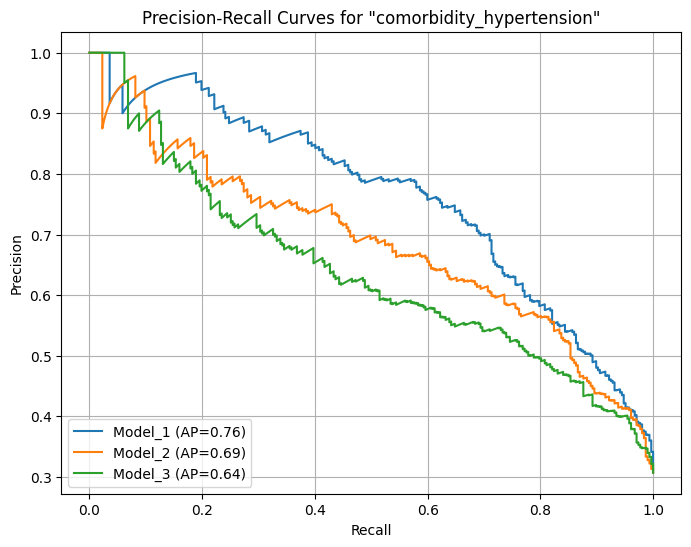

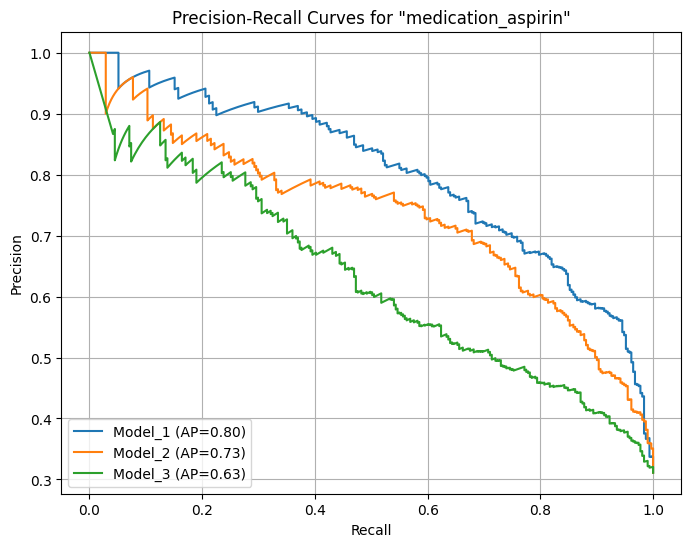

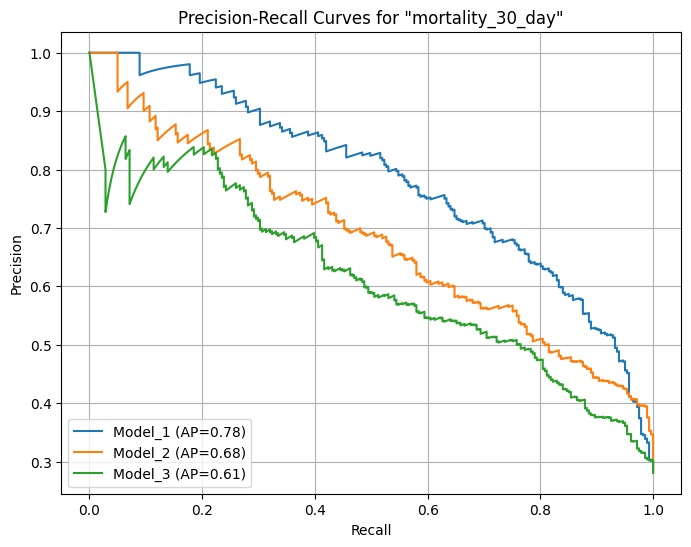

In [62]:
for attribute in attributes:
  plot_pr_curves_all_models(gt_df, model_outputs, attribute, filename=f'{attribute} pr_curve.png', append=True)
  plt.show()
  plt.close()

In [88]:
def generate_image_files(visuals={
    'pr_curve': True,
    'bar_chart': True,
    'summary_table': True
}):
  image_files = []
  if visuals['pr_curve']:
    for attribute in attributes:
      plot_pr_curves_all_models(gt_df, model_outputs, attribute, filename=f'{attribute} pr_curve', append=True)
      plt.close()
  if visuals['bar_chart']:
    for metric in metrics:
      plot_horizontal_bar(summary, metric=metric, figsize=(10, 6), filename='bar_chart', append=True)
      plt.close()
  if visuals['summary_table']:
    styled_metrics_by_model(summary, append=True, show=False)


In [89]:
attributes = ['comorbidity_diabetes', 'comorbidity_hypertension', 'medication_aspirin', 'mortality_30_day']
metrics = ['Precision', 'Recall', 'F1', 'Accuracy', 'Average Precision (AP)', 'Cohen\'s Kappa']
visuals = {
    'pr_curve': True,
    'bar_chart': True,
    'summary_table': True
}

In [90]:
image_files = []
generate_image_files(visuals=visuals)

In [91]:
image_files

['comorbidity_diabetes pr_curve.png',
 'comorbidity_hypertension pr_curve.png',
 'medication_aspirin pr_curve.png',
 'mortality_30_day pr_curve.png',
 'Precision bar_chart.png',
 'Recall bar_chart.png',
 'F1 bar_chart.png',
 'Accuracy bar_chart.png',
 'Average Precision (AP) bar_chart.png',
 "Cohen's Kappa bar_chart.png",
 'summary_metrics.png']

In [92]:
create_pdf_from_images(image_files)

PDF report saved as model_evaluation_report.pdf
